loading the data

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)                         ## Will study in-depth in a next lab
transform = transforms.Compose([
    # normalize
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset  
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders 
# (The Dataset Class loads only one sample at a time. We pass it to dataloader to read batch_size of images at a time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:40<00:00, 4.23MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000, Testing samples: 10000


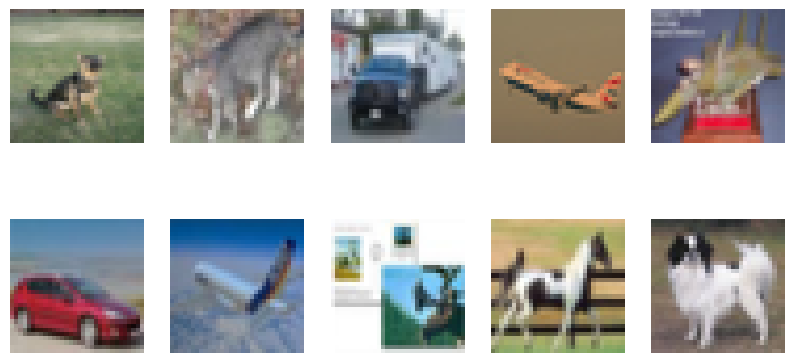

Shape of one image tensor: torch.Size([3, 32, 32])


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)  # Labels are ignored in Autoencoder

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.axis('off')
plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (1, 28, 28)


model structure


In [6]:
import torch.nn as nn

# Define Autoencoder Model
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(CNNAutoEncoder, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),  # (32x32) → (16x16)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(16, 32, 3, 2, 1), # (16x16) → (8x8)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Flatten(),  # Flatten to vector
            nn.Linear(32 * 8 * 8, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 8 * 8),
            nn.BatchNorm1d(32 * 8 * 8),
            nn.LeakyReLU(),
            # unflatten
            nn.Unflatten(1, (32, 8, 8)),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (8x8) → (16x16)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1),  # (16x16) → (32x32)
            nn.Sigmoid(),  # Normalize pixel values
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out

In [7]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0

    for images, _ in tqdm(dataloader):  # Ignore labels since Autoencoders don't use them
        images = images.to(device)

        _, reconstructions = model(images)  # Forward pass (encoder + decoder)
        loss = criterion(reconstructions, images)  # Compute reconstruction loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss  # No accuracy since it's not classification


In [8]:
import torch.optim as optim


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNAutoEncoder(encoding_dim=8).to(device)

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Measure reconstruction quality
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer
num_epochs = 20 # Number of epochs

# Store losses for plotting
train_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {train_loss:.4f}")

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=8, bias=True)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Unflatten(dim=1, unflattened_size=(32, 8, 8))
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), p

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:36<00:00, 42.71it/s] 


Epoch 1/20, Loss = 0.0429


100%|██████████| 1563/1563 [00:36<00:00, 43.18it/s] 


Epoch 2/20, Loss = 0.0297


100%|██████████| 1563/1563 [00:38<00:00, 40.89it/s] 


Epoch 3/20, Loss = 0.0283


100%|██████████| 1563/1563 [00:42<00:00, 36.40it/s]


Epoch 4/20, Loss = 0.0277


100%|██████████| 1563/1563 [00:41<00:00, 37.95it/s] 


Epoch 5/20, Loss = 0.0273


100%|██████████| 1563/1563 [00:28<00:00, 55.42it/s] 


Epoch 6/20, Loss = 0.0270


100%|██████████| 1563/1563 [00:27<00:00, 56.60it/s] 


Epoch 7/20, Loss = 0.0269


100%|██████████| 1563/1563 [00:37<00:00, 41.96it/s] 


Epoch 8/20, Loss = 0.0267


100%|██████████| 1563/1563 [00:39<00:00, 39.70it/s] 


Epoch 9/20, Loss = 0.0266


100%|██████████| 1563/1563 [00:37<00:00, 41.18it/s] 


Epoch 10/20, Loss = 0.0264


100%|██████████| 1563/1563 [00:33<00:00, 46.05it/s] 


Epoch 11/20, Loss = 0.0264


100%|██████████| 1563/1563 [00:27<00:00, 56.23it/s] 


Epoch 12/20, Loss = 0.0263


100%|██████████| 1563/1563 [00:28<00:00, 55.81it/s] 


Epoch 13/20, Loss = 0.0262


100%|██████████| 1563/1563 [00:32<00:00, 47.96it/s] 


Epoch 14/20, Loss = 0.0262


100%|██████████| 1563/1563 [00:33<00:00, 47.16it/s] 


Epoch 15/20, Loss = 0.0261


100%|██████████| 1563/1563 [00:40<00:00, 38.41it/s] 


Epoch 16/20, Loss = 0.0260


100%|██████████| 1563/1563 [00:40<00:00, 38.95it/s] 


Epoch 17/20, Loss = 0.0260


100%|██████████| 1563/1563 [00:41<00:00, 37.27it/s] 


Epoch 18/20, Loss = 0.0259


100%|██████████| 1563/1563 [00:38<00:00, 40.69it/s] 


Epoch 19/20, Loss = 0.0258


100%|██████████| 1563/1563 [00:33<00:00, 46.54it/s] 

Epoch 20/20, Loss = 0.0256


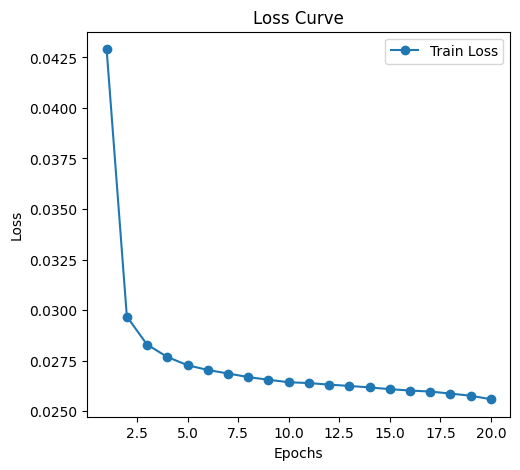

In [9]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

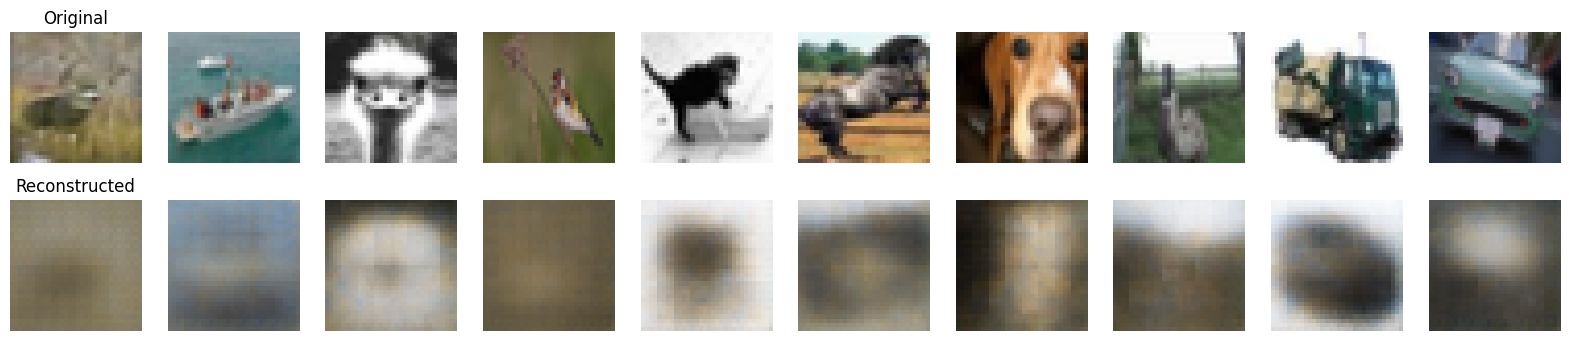

In [11]:
import matplotlib.pyplot as plt

# 🔹 Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)  # Select 'num_images' samples

    # Get reconstructed images
    with torch.no_grad():
        _, reconstructions = model(images)
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i].permute(1, 2, 0))
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()

    

# 🔹 Display Results
show_original_vs_reconstructed(model, train_loader, device)


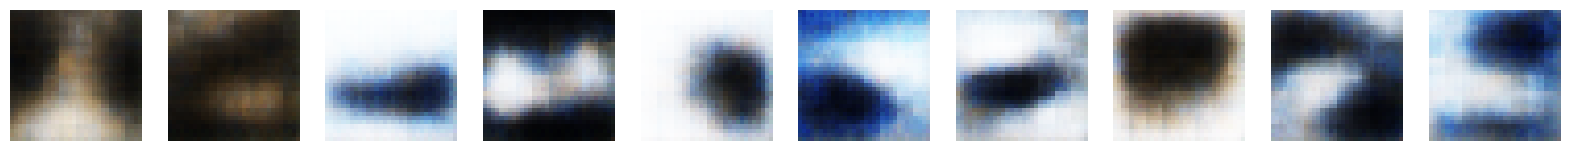

In [17]:
import matplotlib.pyplot as plt
import torch

# 🔹 Function to Generate & Display RGB Images
def generate_images(model, num_images=10, encoding_dim=8):
    model.eval()  # Set to evaluation mode
    
    # Generate random encodings from a uniform distribution in [-1,1]
    random_encodings = (torch.rand(num_images, encoding_dim).to(device) - 0.5) * 2  
    
    # Pass through decoder to generate images
    with torch.no_grad():
        generated_images = model.decoder(random_encodings).cpu()

    # Reshape images correctly → (num_images, 3, 32, 32)
    generated_images = generated_images.view(-1, 3, 32, 32)

    # Normalize to [0,1] for visualization (since output is Sigmoid)
    generated_images = generated_images.permute(0, 2, 3, 1).numpy()  # Change to (H, W, C)

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])  # No cmap, since it's RGB
        ax.axis('off')
    plt.show()

# 🔹 Generate & Display RGB Images
generate_images(model, num_images=10, encoding_dim=8)
